In [1]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import matplotlib.pyplot as plt
import scienceplots

In [2]:
# plt.style.use(["science"])

In [22]:
N_DOF_FD = 100
N_COLLOCATION_POINTS = 50
LEARNING_RATE = 0.001
N_OPTIMIZATION_EPOCHS = 10000
BC_LOSS_WEIGHT = 100.0

In [4]:
key = jr.PRNGKey(42)

In [5]:
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size="scalar",
    out_size="scalar",
    width_size=10,
    depth=4,
    activation=jax.nn.sigmoid,
    key=key,
)

In [6]:
mesh_full = jnp.linspace(0.0, 1.0, N_DOF_FD + 2)
mesh_interior = mesh_full[1:-1]

In [7]:
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1.0, 0.0)

In [8]:
rhs_evaluated = rhs_function(mesh_interior)

In [9]:
dx = mesh_interior[1] - mesh_interior[0]
A = jnp.diag(jnp.ones(N_DOF_FD - 1), -1) + jnp.diag(jnp.ones(N_DOF_FD - 1), 1) - jnp.diag(2 * jnp.ones(N_DOF_FD), 0)
A /= dx**2

In [10]:
FD_sol = jnp.linalg.solve(A, -rhs_evaluated)

In [11]:
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode="constant")

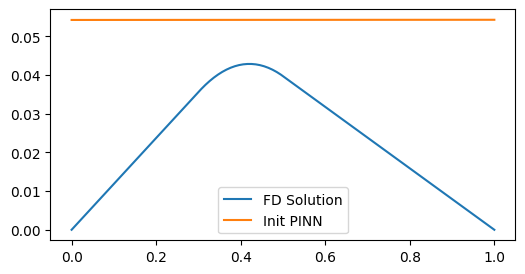

In [12]:
fig, ax = plt.subplots(figsize=(6, 3))
# plt.plot(mesh_full, wrap_bc(rhs_evaluated), label="Forcing Function")
plt.plot(mesh_full, wrap_bc(FD_sol), label="FD Solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Init PINN")
plt.legend()

In [13]:
def pde_residuum(network, x):
    return jax.grad(jax.grad(network))(x) + rhs_function(x)

In [14]:
pde_residuum(pinn, 0.8)

Array(-2.8515838e-05, dtype=float32)

In [31]:
key, sampling_key = jr.split(key)
collocation_points = jr.uniform(sampling_key, (N_COLLOCATION_POINTS, ), minval=0.0 + 1e-2, maxval=1.0 - 1e-2)

def loss_fn(network):
    pde_res_coll = jax.vmap(pde_residuum, in_axes=(None, 0))(network, collocation_points)
    pde_loss = jnp.mean(jnp.square(pde_res_coll))
    
    left_bc_res = network(0.0) - 0.0
    right_bc_res = network(1.0) - 0.0
    bc_loss = jnp.mean(jnp.square(left_bc_res)) + jnp.mean(jnp.square(right_bc_res))

    total_loss = 0.5 * (pde_loss + BC_LOSS_WEIGHT * bc_loss)
    
    return total_loss

In [32]:
loss_fn(pinn)

Array(0.01537727, dtype=float32)

In [33]:
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

loss_history = np.zeros(N_OPTIMIZATION_EPOCHS)

for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history[epoch] = loss
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 0.015377274714410305
Epoch: 10, loss: 0.010287529788911343
Epoch: 20, loss: 0.009935759007930756
Epoch: 30, loss: 0.009600740857422352
Epoch: 40, loss: 0.009152735583484173
Epoch: 50, loss: 0.00898064486682415
Epoch: 60, loss: 0.00885799154639244
Epoch: 70, loss: 0.008760818280279636
Epoch: 80, loss: 0.008684912696480751
Epoch: 90, loss: 0.008630991913378239
Epoch: 100, loss: 0.008588124997913837
Epoch: 110, loss: 0.008554420433938503
Epoch: 120, loss: 0.008526616729795933
Epoch: 130, loss: 0.008502754382789135
Epoch: 140, loss: 0.008481603115797043
Epoch: 150, loss: 0.008462593890726566
Epoch: 160, loss: 0.008445310406386852
Epoch: 170, loss: 0.008429617621004581
Epoch: 180, loss: 0.008415253832936287
Epoch: 190, loss: 0.008402129635214806
Epoch: 200, loss: 0.008390378206968307
Epoch: 210, loss: 0.00837978906929493
Epoch: 220, loss: 0.008370188064873219
Epoch: 230, loss: 0.00836174376308918
Epoch: 240, loss: 0.00835424941033125
Epoch: 250, loss: 0.008347578346729279
Ep

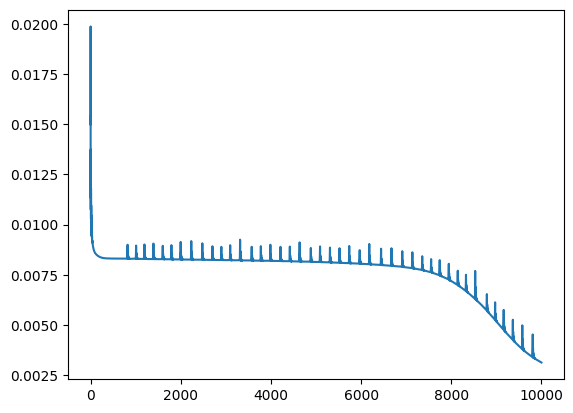

In [34]:
plt.plot(loss_history)

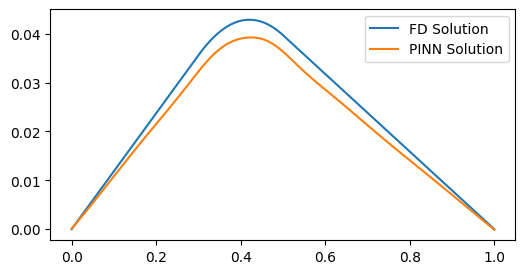

In [36]:
fig, ax = plt.subplots(figsize=(6, 3))
# plt.plot(mesh_full, wrap_bc(rhs_evaluated), label="Forcing Function")
plt.plot(mesh_full, wrap_bc(FD_sol), label="FD Solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="PINN Solution")
plt.legend()